In [ ]:
from __future__ import annotations
from typing import Dict, List, Tuple
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Complejo Vietoris-Rips

In [ ]:
def rips_complex(
    P: np.ndarray,        # conjunto de puntos en R^d (matriz n x d)
    alpha: float,         # umbral de distancia para considerar vecinos
    k_max: int,           # dimensión máxima del complejo
) -> Tuple[Dict[int, List[Tuple[int, ...]]], nx.Graph]:
    
    # Aseguramos que los puntos estén en arreglo numpy tipo float
    P = np.asarray(P, dtype=float)
    n = P.shape[0]  # número de puntos
    assert alpha > 0.0 and k_max >= 0

    # Creamos el grafo G que será el 1-esqueleto (vértices + aristas)
    G = nx.Graph()
    G.add_nodes_from(range(n))  # cada punto es un vértice del grafo

    # Calculamos la matriz de distancias euclidianas entre todos los pares de puntos
    diff = P[:, None, :] - P[None, :, :]
    D = np.sqrt(np.sum(diff * diff, axis=-1))

    # Recorremos solo la mitad superior de la matriz (i<j) para no repetir
    inds = np.transpose(np.triu_indices(n, k=1))
    for i, j in inds:
        # Si la distancia es menor o igual a alpha, añadimos la arista (i,j)
        if D[i, j] <= alpha:
            G.add_edge(i, j)

    # Número máximo de vértices en un símplice = k_max + 1
    s_max = k_max + 1

    # Diccionario que guarda listas de símplices agrupados por dimensión
    # Ej: K_by_dim[0] = vértices, K_by_dim[1] = aristas, K_by_dim[2] = triángulos
    K_by_dim: Dict[int, List[Tuple[int, ...]]] = {k: [] for k in range(k_max + 1)}

    # Enumeramos todas las cliques del grafo (subconjuntos completos de vértices)
    for clique in nx.enumerate_all_cliques(G):
        s = len(clique)  # tamaño del clique
        if s > s_max:    # si sobrepasa el máximo, paramos
            break
        # Ordenamos y lo guardamos como tupla para representación canónica
        simplex = tuple(sorted(clique))
        k = s - 1  # un clique de tamaño s corresponde a un (s-1)-símplice
        K_by_dim[k].append(simplex)

    # Retornamos el complejo por dimensiones y el grafo 1-esqueleto
    return K_by_dim, G


### Visualización

In [24]:
def plot_rips(P: np.ndarray, K_by_dim: Dict[int, List[Tuple[int, ...]]], k_max: int, show_labels: bool = True):
    """Simple visualization up to k=2 (vértices, aristas y triángulos)."""
    P = np.asarray(P, dtype=float)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal', 'box')

    # 2-simplices (triángulos) como polígonos rellenados muy suaves
    if k_max >= 2 and 2 in K_by_dim:
        for tri in K_by_dim[2]:
            pts = P[list(tri)]
            ax.fill(pts[:, 0], pts[:, 1], alpha=0.20, linewidth=0.5)

    # 1-simplices (aristas)
    if k_max >= 1 and 1 in K_by_dim:
        for (i, j) in K_by_dim[1]:
            xi, yi = P[i]
            xj, yj = P[j]
            ax.plot([xi, xj], [yi, yj], linewidth=1.0)

    # 0-simplices (vértices)
    ax.scatter(P[:, 0], P[:, 1], s=40, zorder=3)
    if show_labels:
        for idx, (x, y) in enumerate(P):
            ax.text(x, y, f"{idx}", fontsize=9, va='bottom', ha='right')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Vietoris–Rips (hasta k=2)")
    plt.tight_layout()
    return fig, ax

### Ejemplo

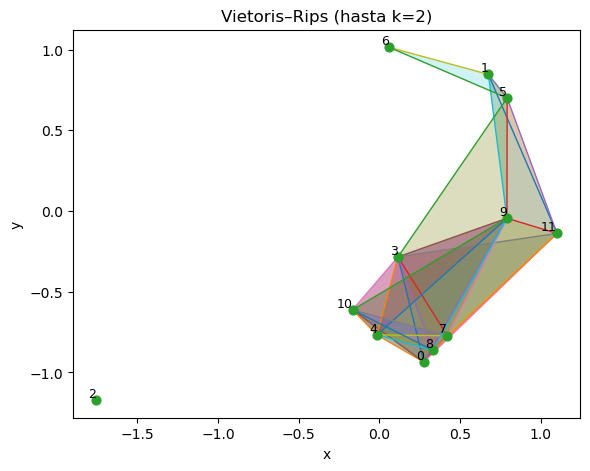

In [31]:
rng = np.random.default_rng(42)
P = rng.normal(size=(12, 2)) * 0.9
alpha = 1.25
k_max = 2

K, G = rips_complex(P, alpha, k_max)
fig, ax = plot_rips(P, K, k_max, show_labels=True)

plt.show()


### Ejemplo con distintos alpha

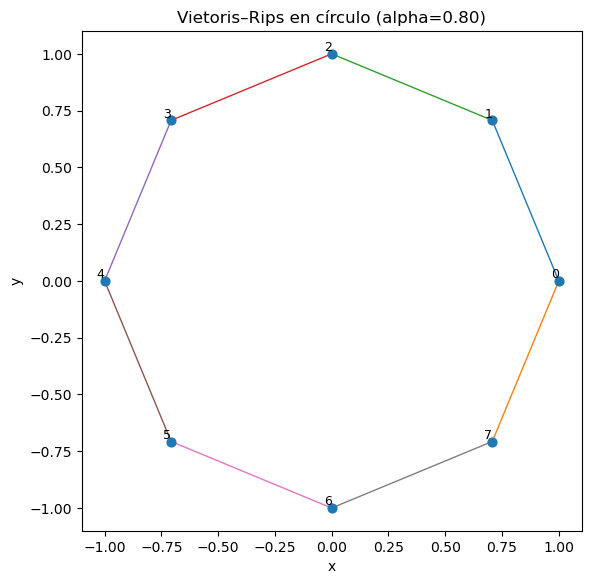

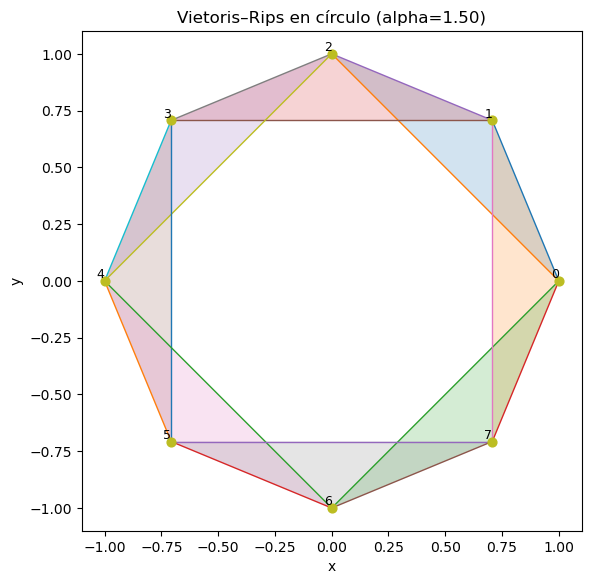

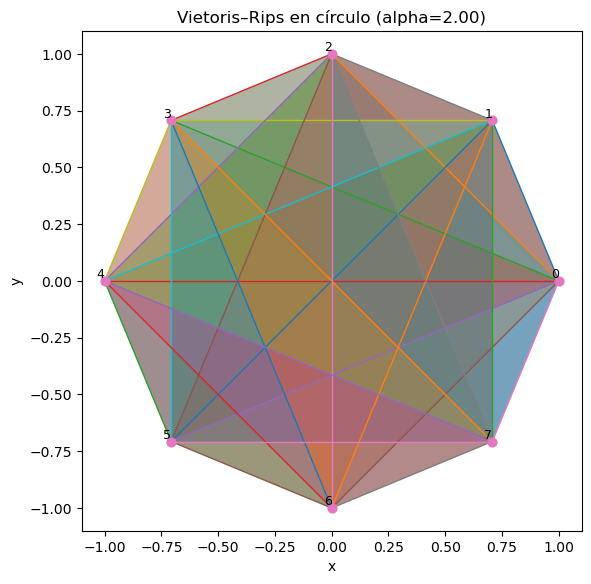

In [27]:
theta = np.linspace(0, 2*np.pi, 8, endpoint=False)
P_circle = np.c_[np.cos(theta), np.sin(theta)]

# Tres valores de alpha para ilustrar
alphas = [0.8, 1.5, 2.0]
k_max = 2
for alpha in alphas:
    K, G = rips_complex(P_circle, alpha, k_max)
    fig, ax = plot_rips(P_circle, K, k_max=2, show_labels=True)
    ax.set_title(f"Vietoris–Rips en círculo (alpha={alpha:.2f})")
    plt.show()
